
## Data Descrbtion 

In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.


---


## Goals

You must create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place).


---


## Data Fields

* DBNOs - Number of enemy players knocked.

* assists - Number of enemy players this player damaged that were killed by teammates.

* boosts - Number of boost items used.

* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

* headshotKills - Number of enemy players killed with headshots.

* heals - Number of healing items used.

* Id - Player’s Id

* killPlace - Ranking in match of number of enemy players killed.

* killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

* killStreaks - Max number of enemy players killed in a short amount of time.

* kills - Number of enemy players killed.

* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

* matchDuration - Duration of match in seconds.

* matchId - ID to identify match. There are no matches that are in both the training and testing set.

* matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

* rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

* revives - Number of times this player revived teammates.

* rideDistance - Total distance traveled in vehicles measured in meters.

* roadKills - Number of kills while in a vehicle.

* swimDistance - Total distance traveled by swimming measured in meters.

* teamKills - Number of times this player killed a teammate.

* vehicleDestroys - Number of vehicles destroyed.

* walkDistance - Total distance traveled on foot measured in meters.

* weaponsAcquired - Number of weapons picked up.

* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.

* groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

* numGroups - Number of groups we have data for in the match.

* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

* winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match

## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')
pd.options.display.max_columns = None

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Dataset

In [ ]:
def reduce_memory_usage(df, execlude=[]):

  for col in [c for c in df.columns if c not in execlude]:

    dtype = str(df[col].dtype)

    if dtype == 'object':
      df[col] = df[col].astype('category')

    elif dtype[:3] == 'int':

      col_max = df[col].max()
      col_min = df[col].min()

      if (col_min >= np.iinfo(np.int8).min) and (col_max <= np.iinfo(np.int8).max):
        df[col] = df[col].astype('int8')
      
      elif (col_min >= np.iinfo(np.int16).min) and (col_max <= np.iinfo(np.int16).max):
        df[col] = df[col].astype('int16')

      elif (col_min >= np.iinfo(np.int32).min) and (col_max <= np.iinfo(np.int32).max):
        df[col] = df[col].astype('int32')
      
      else:
        df[col] = df[col].astype('int64')

    elif dtype[:5] == 'float':

      col_max = df[col].max()
      col_min = df[col].min()
      
      if (col_min >= np.finfo(np.float16).min) and (col_max <= np.finfo(np.float16).max):
        df[col] = df[col].astype('float16')
      
      elif (col_min >= np.finfo(np.float32).min) and (col_max <= np.finfo(np.float32).max):
        df[col] = df[col].astype('float32')

      else:
        df[col] = df[col].astype('float64')

In [ ]:
train_path = "./drive/MyDrive/datasets/PUBG_Finish_Placement_Prediction/train_V2.csv"
df = pd.read_csv(filepath_or_buffer=train_path,
                 index_col=["Id", "groupId", "matchId"]
                 )
reduce_memory_usage(df)
df.head()

,,,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
Id,groupId,matchId,,,,,,,,,,,,,,,,,,,,,,,,,,
7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,0,0.00000,1306,squad-fpp,28,26,-1,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,0,0.00000,1777,squad-fpp,26,25,1484,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,0,0.00000,1318,duo,50,47,1491,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0,0.00000,1436,squad-fpp,31,30,1408,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,1,58.53125,1424,solo-fpp,97,95,1560,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4446966 entries, ('7f96b2f878858a', '4d4b580de459be', 'a10357fd1a4a91') to ('0d8e7ed728b6fd', '8c74f72fedf5ff', '62a16aabcc095c')
Data columns (total 26 columns):
 #   Column           Dtype   
---  ------           -----   
 0   assists          int8    
 1   boosts           int8    
 2   damageDealt      float16 
 3   DBNOs            int8    
 4   headshotKills    int8    
 5   heals            int8    
 6   killPlace        int8    
 7   killPoints       int16   
 8   kills            int8    
 9   killStreaks      int8    
 10  longestKill      float16 
 11  matchDuration    int16   
 12  matchType        category
 13  maxPlace         int8    
 14  numGroups        int8    
 15  rankPoints       int16   
 16  revives          int8    
 17  rideDistance     float16 
 18  roadKills        int8    
 19  swimDistance     float16 
 20  teamKills        int8    
 21  vehicleDestroys  int8    
 22  walkDistance     float16 
 23  weapons

## Data Cleaning

In [ ]:
# rankpoints, killPoints, winPoints => depercated features 
df.drop(columns=["rankPoints", "killPoints", "winPoints"], inplace=True)

In [ ]:
# maxPlace is irrelevent => drop
df.drop(columns=["maxPlace"], inplace=True)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4446965 entries, ('7f96b2f878858a', '4d4b580de459be', 'a10357fd1a4a91') to ('0d8e7ed728b6fd', '8c74f72fedf5ff', '62a16aabcc095c')
Data columns (total 22 columns):
 #   Column           Non-Null Count    Dtype   
---  ------           --------------    -----   
 0   assists          4446965 non-null  int8    
 1   boosts           4446965 non-null  int8    
 2   damageDealt      4446965 non-null  float16 
 3   DBNOs            4446965 non-null  int8    
 4   headshotKills    4446965 non-null  int8    
 5   heals            4446965 non-null  int8    
 6   killPlace        4446965 non-null  int8    
 7   kills            4446965 non-null  int8    
 8   killStreaks      4446965 non-null  int8    
 9   longestKill      4446965 non-null  float16 
 10  matchDuration    4446965 non-null  int16   
 11  matchType        4446965 non-null  category
 12  numGroups        4446965 non-null  int8    
 13  revives          4446965 non-null  int8    
 14

## Data Exploration

### Match related features

In [ ]:
print(f"{ {k: v for k, v in zip(df.index.names, df.index.levshape)} }")

{'Id': 4446966, 'groupId': 2026745, 'matchId': 47965}


In [ ]:
matchs_df = df.groupby(level=["matchId"]).agg({
    "numGroups": "first",
    "matchType": "first",
    "matchDuration": "first",    
})
matchs_df["totalnumPlayers"] = df.groupby(level=["matchId"]).size()
matchs_df.head()

,numGroups,matchType,matchDuration,totalnumPlayers
matchId,,,,
0000a43bce5eec,28,squad-fpp,1346,95
0000eb01ea6cdd,27,squad-fpp,1363,98
0002912fe5ed71,92,solo,1949,95
0003b92987589e,47,duo,1410,100
0006eb8c17708d,44,duo-fpp,1382,93


In [ ]:
def group_lowers(data, percentage=0.99, name="other"):

    x = data.sort_values(ascending=False)
    x = x[x.cumsum() / x.sum() <= percentage]

    lower_group = data[[i for i in data.index if i not in x.index]]

    x[name] = data.sum() - x.sum()

    return x, lower_group

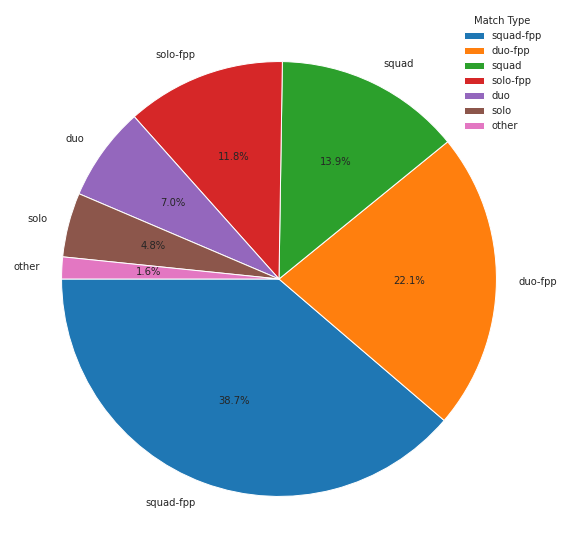

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))

x, other = group_lowers(matchs_df["matchType"].value_counts())
ax.pie(x=x,
       labels=x.index,
       autopct="%.1f%%",
       startangle=180)
ax.legend(labels=x.index, title="Match Type")

plt.show()

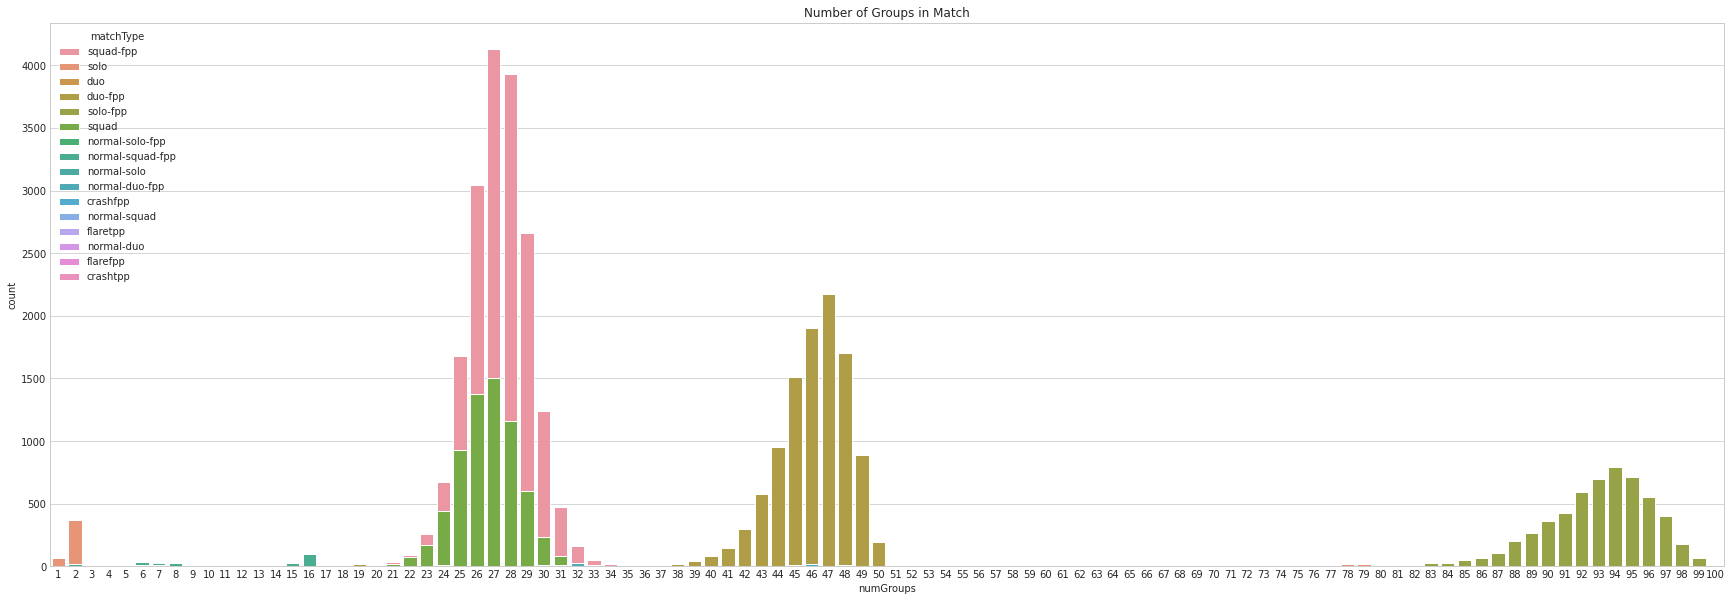

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.countplot(data=matchs_df,
              x='numGroups',
              hue='matchType',
              dodge=False,
              )
ax.set_title("Number of Groups in Match")
plt.show()

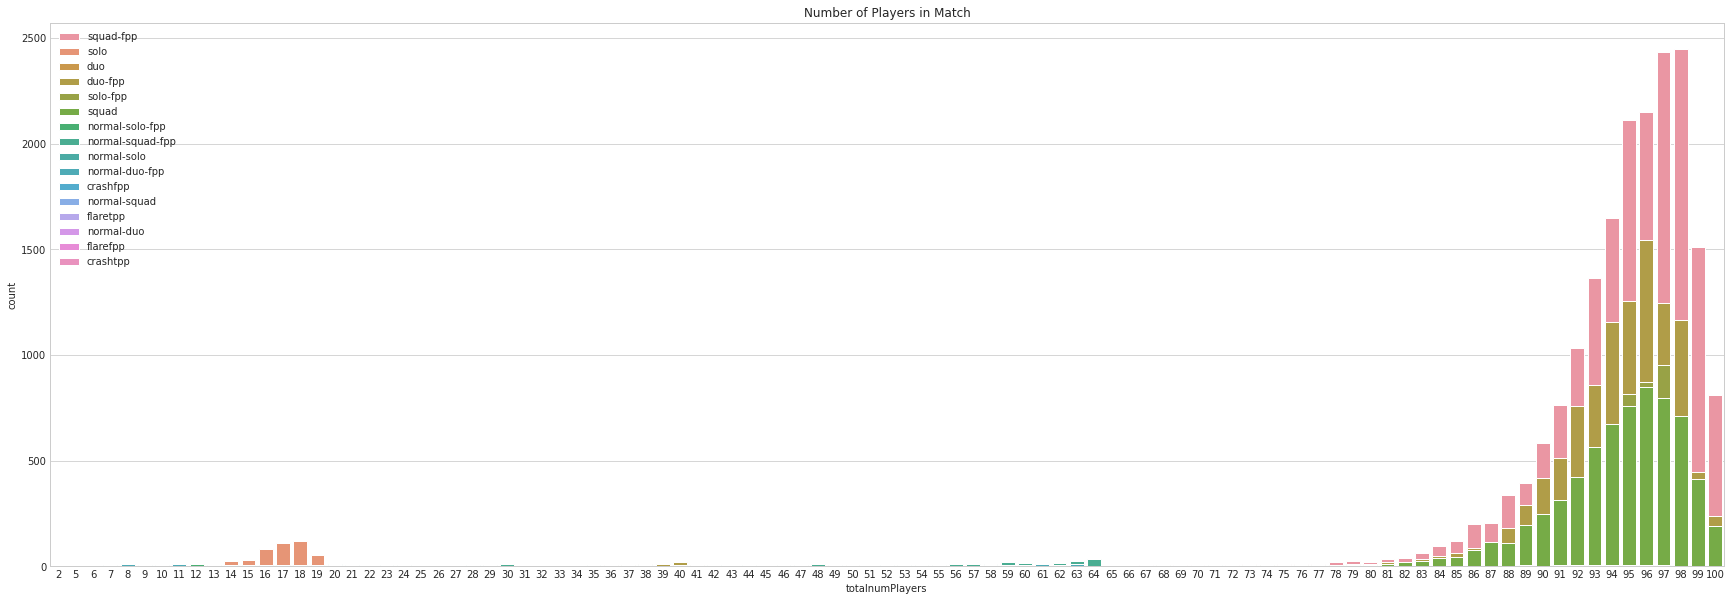

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.countplot(data=matchs_df,
              x='totalnumPlayers',
              hue='matchType',
              dodge=False,
              )
ax.set_title("Number of Players in Match")
ax.legend(loc="upper left")
plt.show()

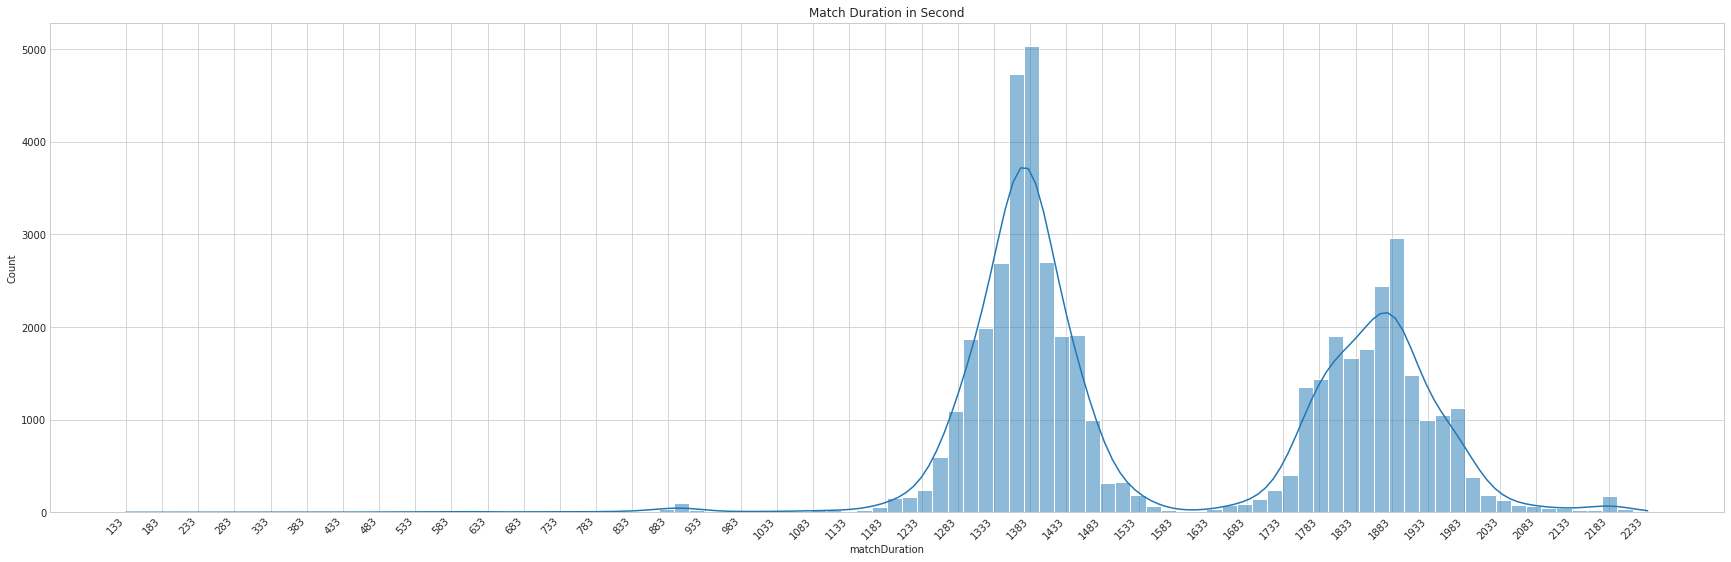

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.histplot(data=matchs_df,
             x="matchDuration",
             bins=100,
             kde=True)
ax.set_xticks(ticks=np.arange(start=matchs_df["matchDuration"].min(),
                              stop=matchs_df["matchDuration"].max(),
                              step=50))
ax.set_title("Match Duration in Second")
fig.autofmt_xdate(rotation=45)
plt.show()

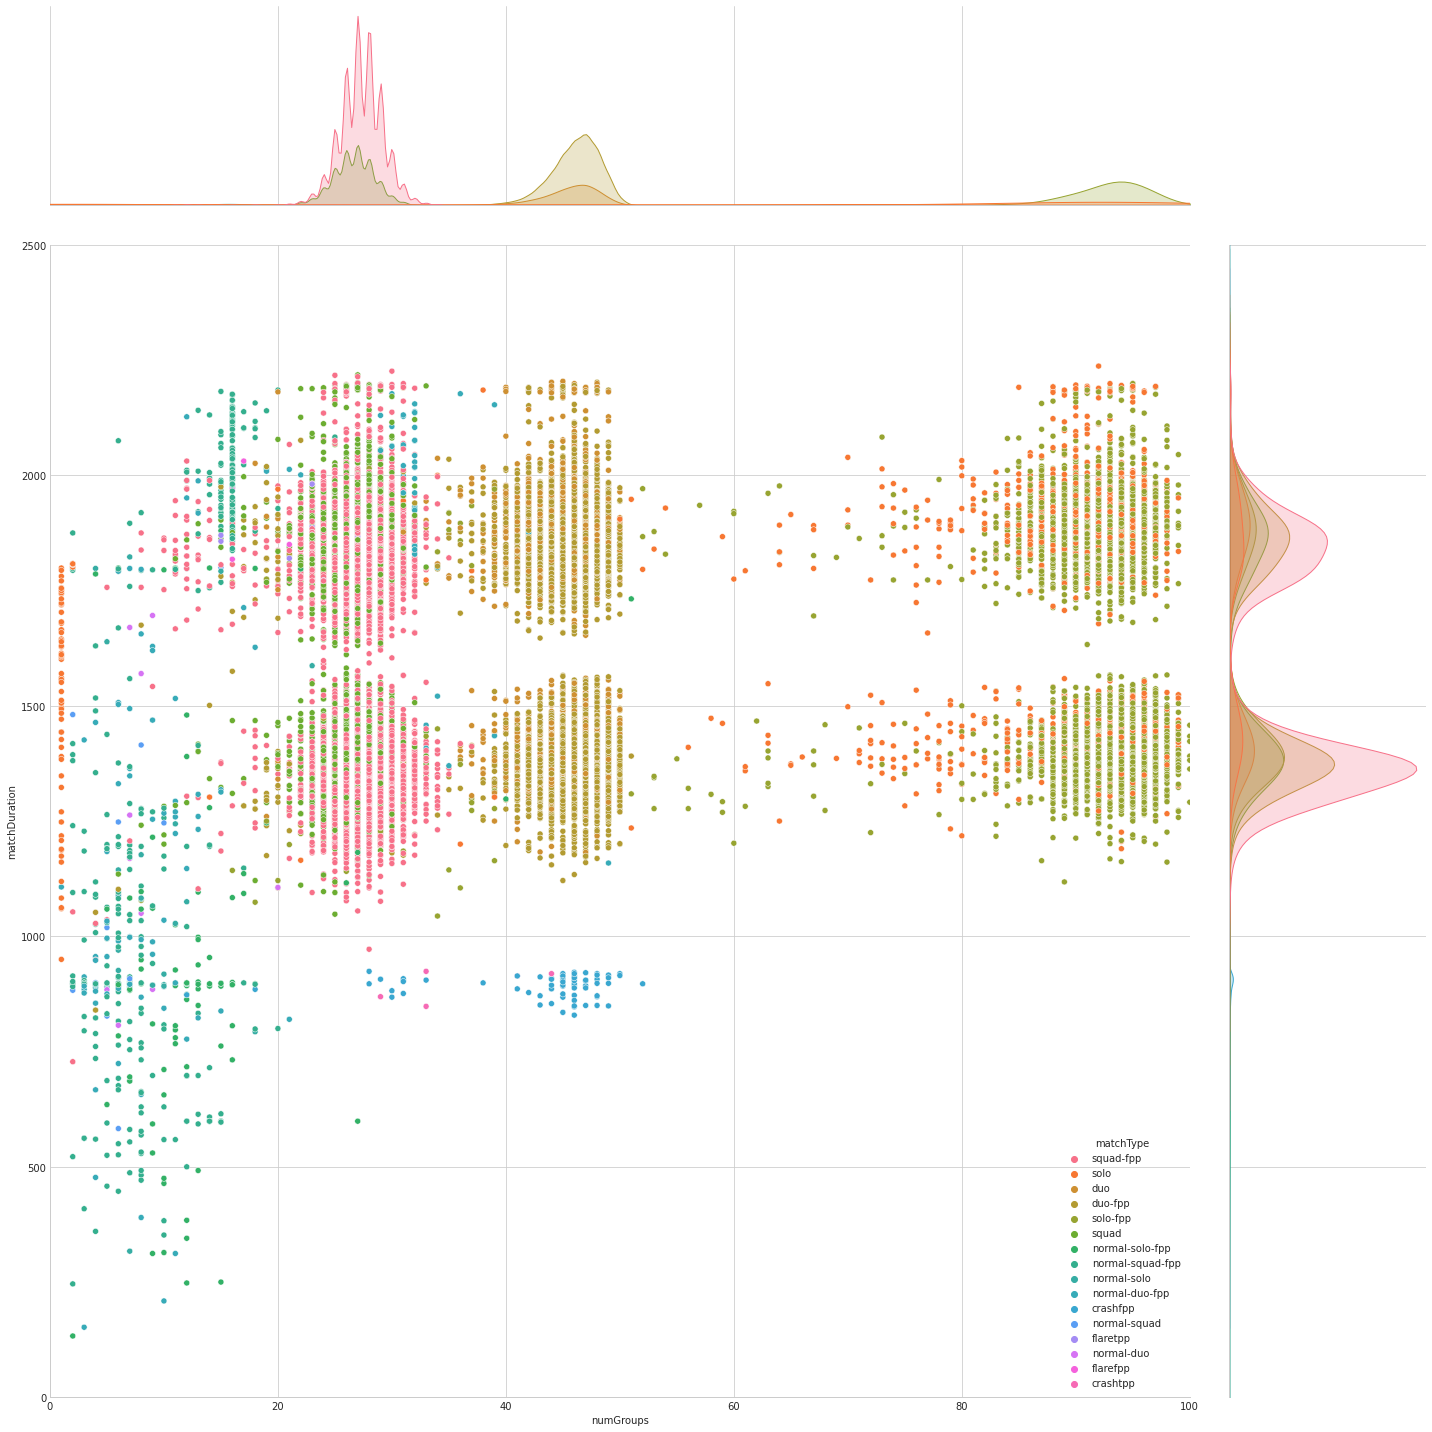

In [ ]:
sns.jointplot(data=matchs_df, x='numGroups', y='matchDuration', hue="matchType", height=20, xlim=(0, 100), ylim=(0, 2500))

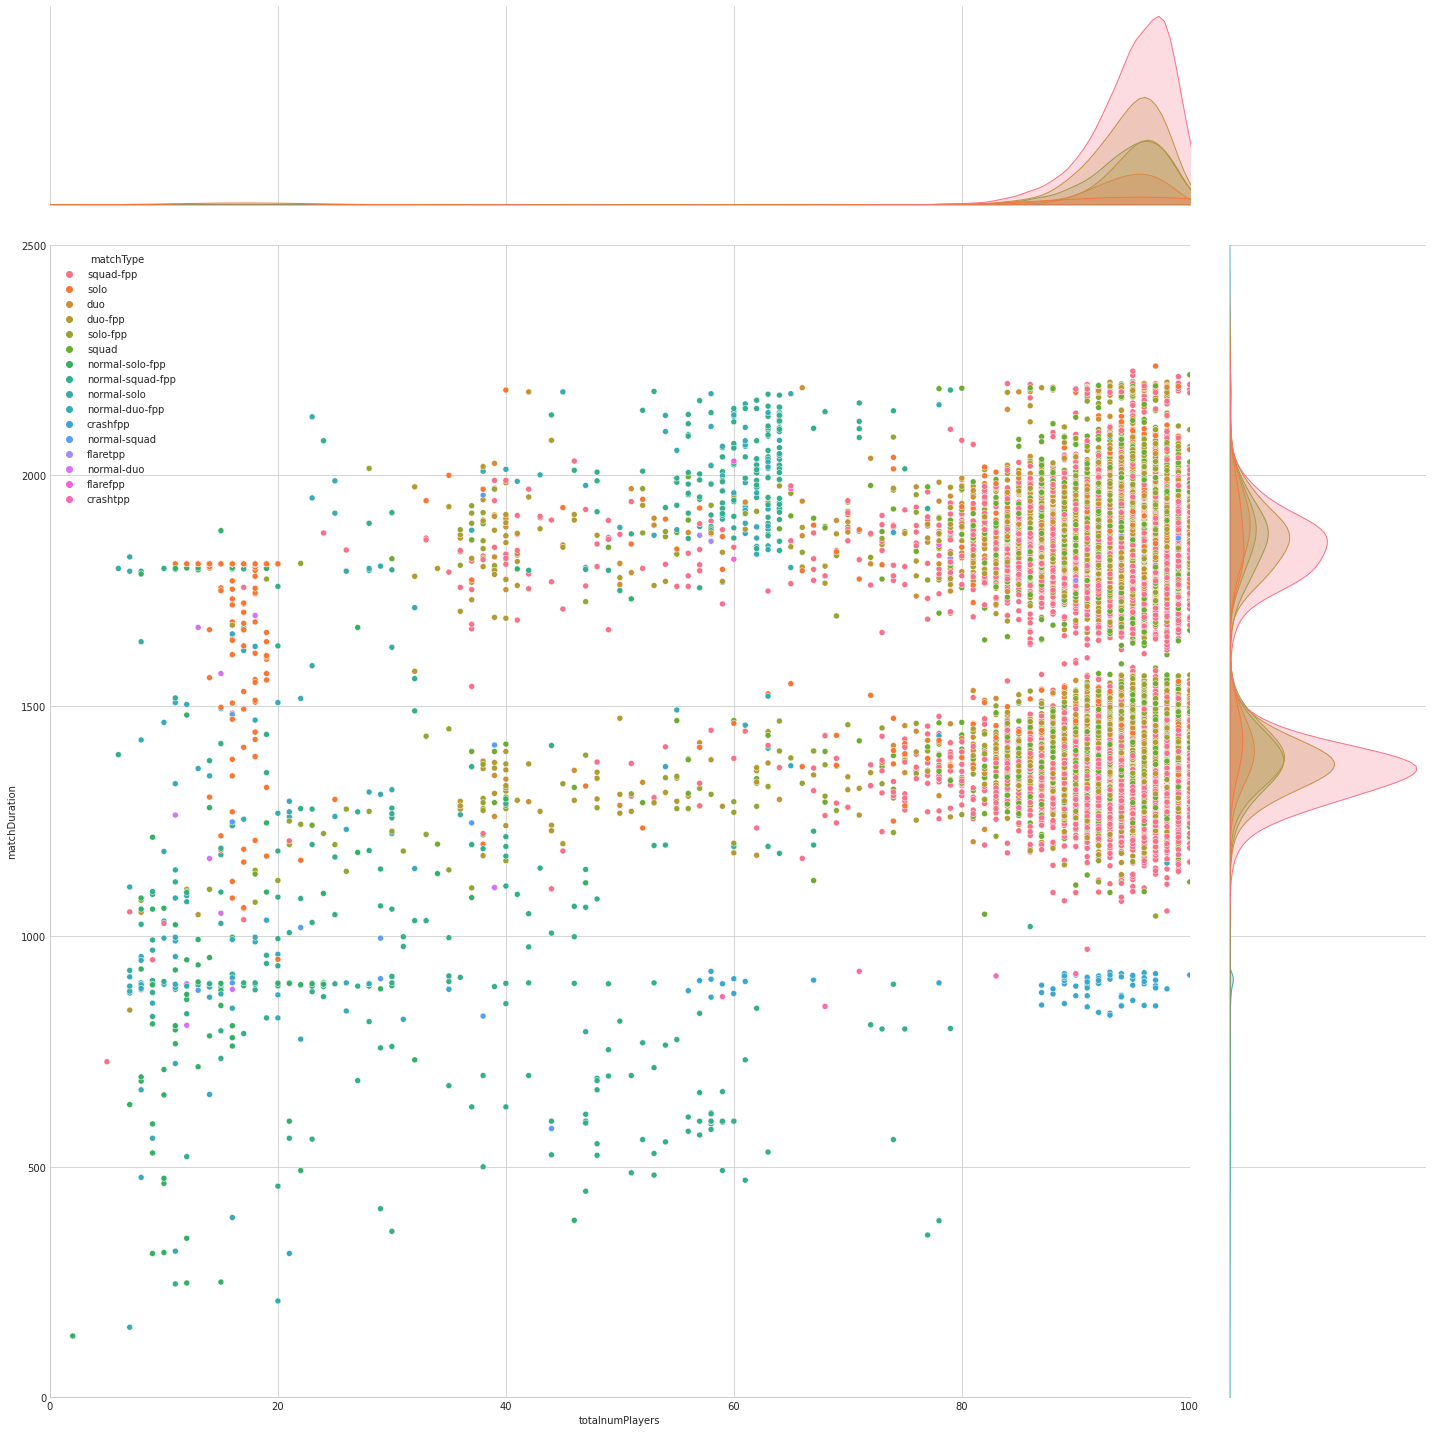

In [ ]:
sns.jointplot(data=matchs_df, x='totalnumPlayers', y='matchDuration', hue="matchType", height=20, xlim=(0, 100), ylim=(0, 2500))

In [ ]:
matchs_df.describe().drop(index="count").T

,mean,std,min,25%,50%,75%,max
numGroups,42.255525,23.491622,1.0,27.0,29.0,47.0,100.0
matchDuration,1578.999708,264.227248,133.0,1366.0,1440.0,1850.0,2237.0
totalnumPlayers,92.714640,11.714801,2.0,93.0,95.0,97.0,100.0


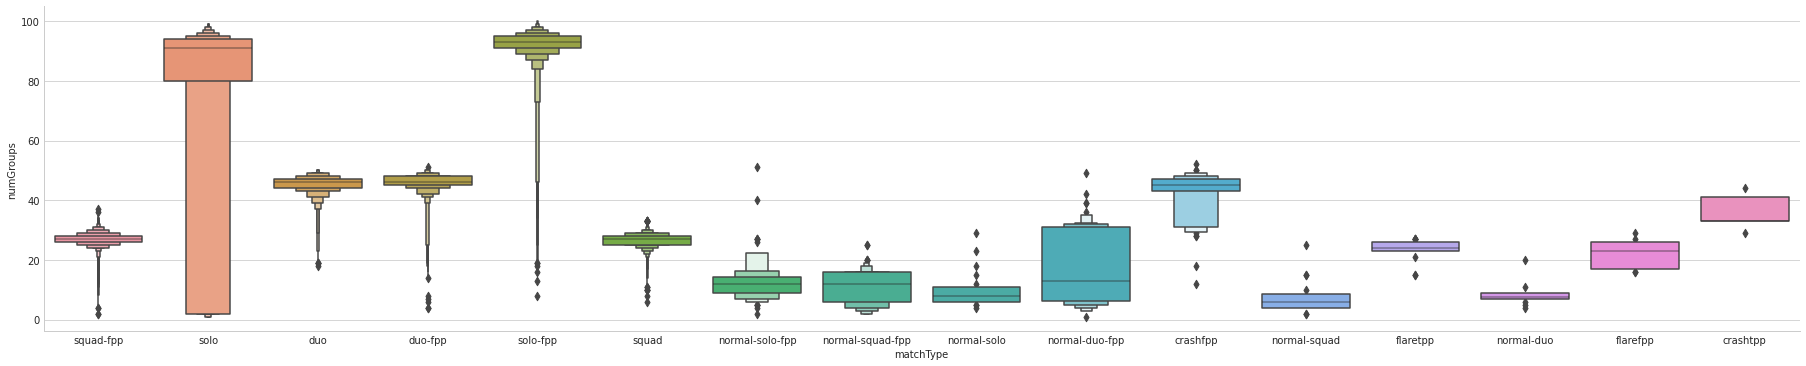

In [ ]:
sns.catplot(data=matchs_df, y="numGroups", x="matchType", kind="boxen", height=5, aspect=5)

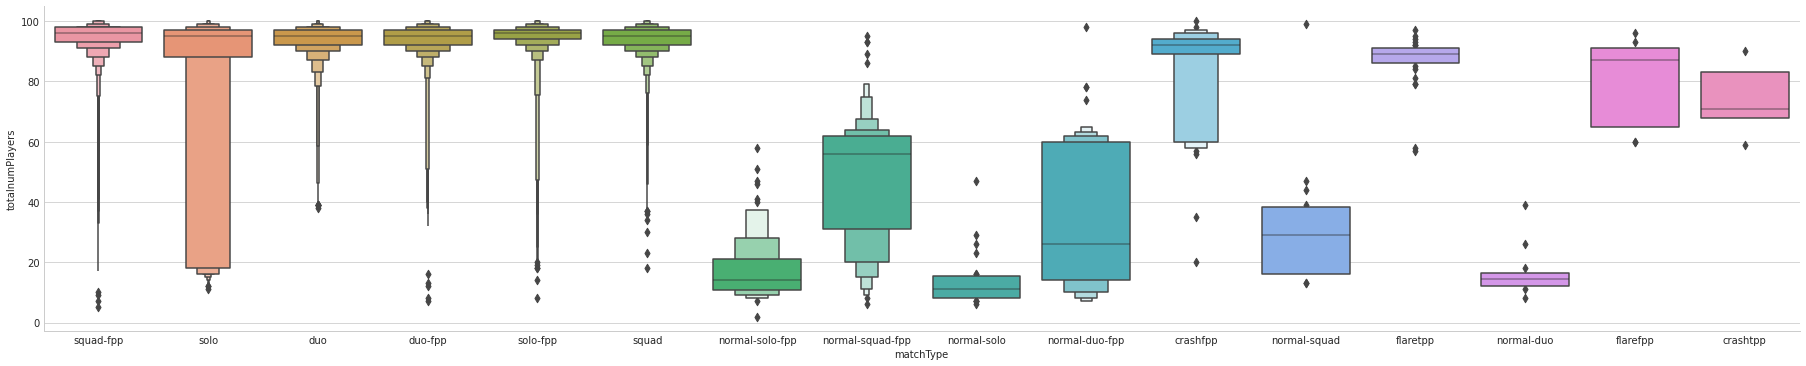

In [ ]:
sns.catplot(data=matchs_df, y="totalnumPlayers", x="matchType", kind="boxen", height=5, aspect=5)

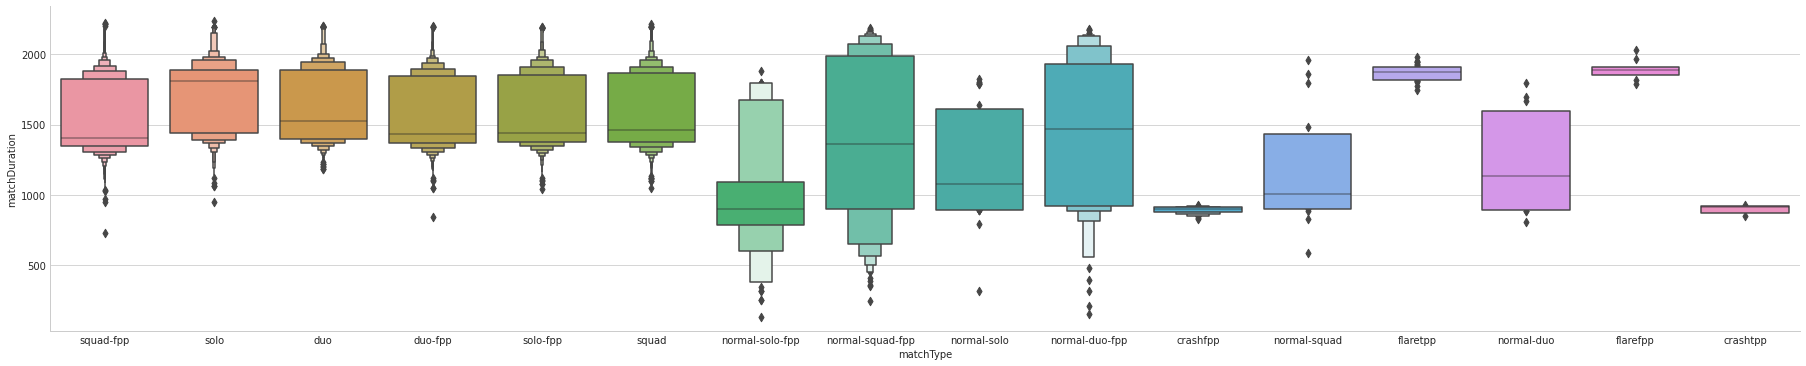

In [ ]:
sns.catplot(data=matchs_df, y="matchDuration", x="matchType", kind="boxen", height=5, aspect=5)

### Groups Realted Features

In [ ]:
groups_df = df.groupby(level=["matchId", "groupId"]).agg({
    "boosts": "sum",
    "heals": "sum",
    "revives": "sum",
    "damageDealt": "sum",
    "kills": "sum",
    "headshotKills": "sum",
    "roadKills": "sum",
    "teamKills": "sum",
    "assists": "sum",
    "killStreaks": "max",
    "longestKill": "max",
    "DBNOs": "sum",
    "vehicleDestroys": "sum",
    "walkDistance": "sum",
    "rideDistance": "sum",
    "swimDistance": "sum",
    "winPlacePerc": "first"
})
groups_df["totalDistance"] = groups_df["walkDistance"] + groups_df["rideDistance"] + groups_df["swimDistance"]
groups_df["numOfTeamPlayers"] = df.groupby(level=["matchId", "groupId"]).size()
groups_df = groups_df.merge(right=matchs_df["totalnumPlayers"], on=["matchId"])
groups_df["numOfEnemyPlayers"] = groups_df["totalnumPlayers"] - groups_df["numOfTeamPlayers"]

groups_df.head()

,boosts,heals,revives,damageDealt,kills,headshotKills,roadKills,teamKills,assists,killStreaks,longestKill,DBNOs,vehicleDestroys,walkDistance,rideDistance,swimDistance,winPlacePerc,totalDistance,numOfTeamPlayers,totalnumPlayers,numOfEnemyPlayers
matchId,,,,,,,,,,,,,,,,,,,,,
0000a43bce5eec,1,1.0,0,219.37500,2.0,0,0,0,0,1,12.546875,2,0,263.500000,0.000,0.00000,0.333252,263.500000,2,95,93
0000a43bce5eec,0,0.0,0,288.00000,0.0,0,0,0,0,0,0.000000,2,0,119.562500,0.000,0.00000,0.036987,119.562500,6,95,89
0000a43bce5eec,0,0.0,0,0.00000,0.0,0,0,0,0,0,0.000000,0,0,9.632812,0.000,0.00000,0.000000,9.632812,2,95,93
0000a43bce5eec,1,0.0,0,23.40625,0.0,0,0,0,0,0,0.000000,0,0,1118.000000,0.000,0.00000,0.370361,1118.000000,2,95,93
0000a43bce5eec,7,2.0,0,682.00000,6.0,2,0,0,2,2,33.406250,5,0,6584.000000,159.875,11.15625,1.000000,6756.000000,2,95,93


In [ ]:
for col in ["DBNOs", "assists", "damageDealt", "headshotKills", "roadKills", "kills",]:
    groups_df["scaled_" + col] =  (groups_df[col] * groups_df["numOfEnemyPlayers"] / groups_df["numOfTeamPlayers"]) / groups_df["totalnumPlayers"] 

groups_df.head()

,boosts,heals,revives,damageDealt,kills,headshotKills,roadKills,teamKills,assists,killStreaks,longestKill,DBNOs,vehicleDestroys,walkDistance,rideDistance,swimDistance,winPlacePerc,totalDistance,numOfTeamPlayers,totalnumPlayers,numOfEnemyPlayers,scaled_DBNOs,scaled_assists,scaled_damageDealt,scaled_headshotKills,scaled_roadKills,scaled_kills
matchId,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000a43bce5eec,1,1.0,0,219.37500,2.0,0,0,0,0,1,12.546875,2,0,263.500000,0.000,0.00000,0.333252,263.500000,2,95,93,0.978947,0.000000,107.378289,0.000000,0.0,0.978947
0000a43bce5eec,0,0.0,0,288.00000,0.0,0,0,0,0,0,0.000000,2,0,119.562500,0.000,0.00000,0.036987,119.562500,6,95,89,0.312281,0.000000,44.968421,0.000000,0.0,0.000000
0000a43bce5eec,0,0.0,0,0.00000,0.0,0,0,0,0,0,0.000000,0,0,9.632812,0.000,0.00000,0.000000,9.632812,2,95,93,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
0000a43bce5eec,1,0.0,0,23.40625,0.0,0,0,0,0,0,0.000000,0,0,1118.000000,0.000,0.00000,0.370361,1118.000000,2,95,93,0.000000,0.000000,11.456743,0.000000,0.0,0.000000
0000a43bce5eec,7,2.0,0,682.00000,6.0,2,0,0,2,2,33.406250,5,0,6584.000000,159.875,11.15625,1.000000,6756.000000,2,95,93,2.447368,0.978947,333.821053,0.978947,0.0,2.936842


In [ ]:
def get_detailed_grade(x):
    if 0.96 <= x <= 1: return "A+"
    elif 0.92 <= x < 0.96: return "A"
    elif 0.89 <= x < 0.92: return "A-"
    elif 0.86 <= x < 0.89: return "B+"
    elif 0.82 <= x < 0.86: return "B" 
    elif 0.79 <= x < 0.82: return "B-" 
    elif 0.76 <= x < 0.79: return "C+" 
    elif 0.72 <= x < 0.76: return "C" 
    elif 0.69 <= x < 0.72: return "C-" 
    elif 0.66 <= x < 0.69: return "D+" 
    elif 0.62 <= x < 0.66: return "D" 
    elif 0.59 <= x < 0.62: return "D-"
    elif 0.00 <= x < 0.59: return "F"
    else: return "Not in range [0, 1]"

def get_grade(x):
    if 0.90 <= x <= 1: return "A"
    elif 0.80 < x < 0.90: return "B" 
    elif 0.70 < x < 0.80: return "C" 
    elif 0.60 < x < 0.70: return "D" 
    elif 0.00 <= x < 0.60: return "F"
    else: return "Not in range [0, 1]"

In [ ]:
from pandas.api.types import CategoricalDtype

In [ ]:
groups_df["winGrade"] = groups_df["winPlacePerc"].map(lambda val: get_grade(val)).astype(CategoricalDtype(categories=["F", "D", "C", "B", "A"], ordered=True, ))
groups_df.head()

,boosts,heals,revives,damageDealt,kills,headshotKills,roadKills,teamKills,assists,killStreaks,longestKill,DBNOs,vehicleDestroys,walkDistance,rideDistance,swimDistance,winPlacePerc,totalDistance,numOfTeamPlayers,totalnumPlayers,numOfEnemyPlayers,scaled_DBNOs,scaled_assists,scaled_damageDealt,scaled_headshotKills,scaled_roadKills,scaled_kills,winGrade
matchId,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000a43bce5eec,1,1.0,0,219.37500,2.0,0,0,0,0,1,12.546875,2,0,263.500000,0.000,0.00000,0.333252,263.500000,2,95,93,0.978947,0.000000,107.378289,0.000000,0.0,0.978947,F
0000a43bce5eec,0,0.0,0,288.00000,0.0,0,0,0,0,0,0.000000,2,0,119.562500,0.000,0.00000,0.036987,119.562500,6,95,89,0.312281,0.000000,44.968421,0.000000,0.0,0.000000,F
0000a43bce5eec,0,0.0,0,0.00000,0.0,0,0,0,0,0,0.000000,0,0,9.632812,0.000,0.00000,0.000000,9.632812,2,95,93,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,F
0000a43bce5eec,1,0.0,0,23.40625,0.0,0,0,0,0,0,0.000000,0,0,1118.000000,0.000,0.00000,0.370361,1118.000000,2,95,93,0.000000,0.000000,11.456743,0.000000,0.0,0.000000,F
0000a43bce5eec,7,2.0,0,682.00000,6.0,2,0,0,2,2,33.406250,5,0,6584.000000,159.875,11.15625,1.000000,6756.000000,2,95,93,2.447368,0.978947,333.821053,0.978947,0.0,2.936842,A


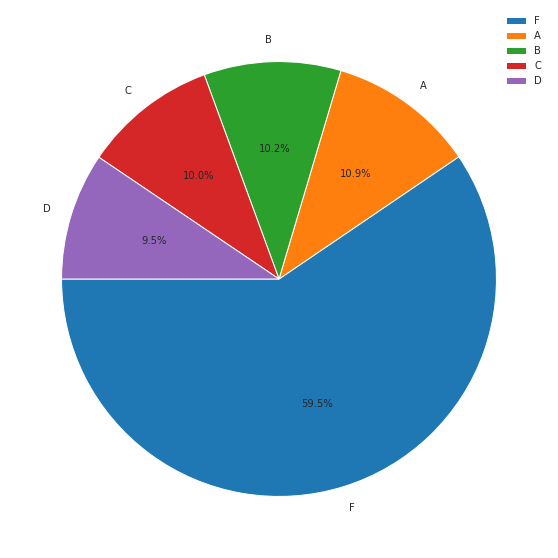

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
x = groups_df["winGrade"].value_counts()
ax.pie(x=x,
       labels=x.index,
       autopct="%.1f%%",
       startangle=180)
ax.legend(labels=x.index)

plt.show()

In [ ]:
groups_df = groups_df.merge(right=matchs_df["matchType"], on=["matchId"])

In [ ]:
groups_df[
          (groups_df["kills"] == 0) &
          (groups_df["assists"] == 0) & 
          (groups_df["DBNOs"] == 0) &
          (groups_df["winGrade"] == "A")
          ]["matchType"].value_counts()

solo-fpp            7015
solo                2520
duo-fpp             2062
squad-fpp            931
duo                  653
squad                324
crashfpp              14
normal-duo-fpp         8
normal-solo-fpp        5
normal-squad-fpp       4
flaretpp               2
crashtpp               1
normal-solo            1
Name: matchType, dtype: int64

In [ ]:
matchs_df["matchType"].dtype

dtype('O')

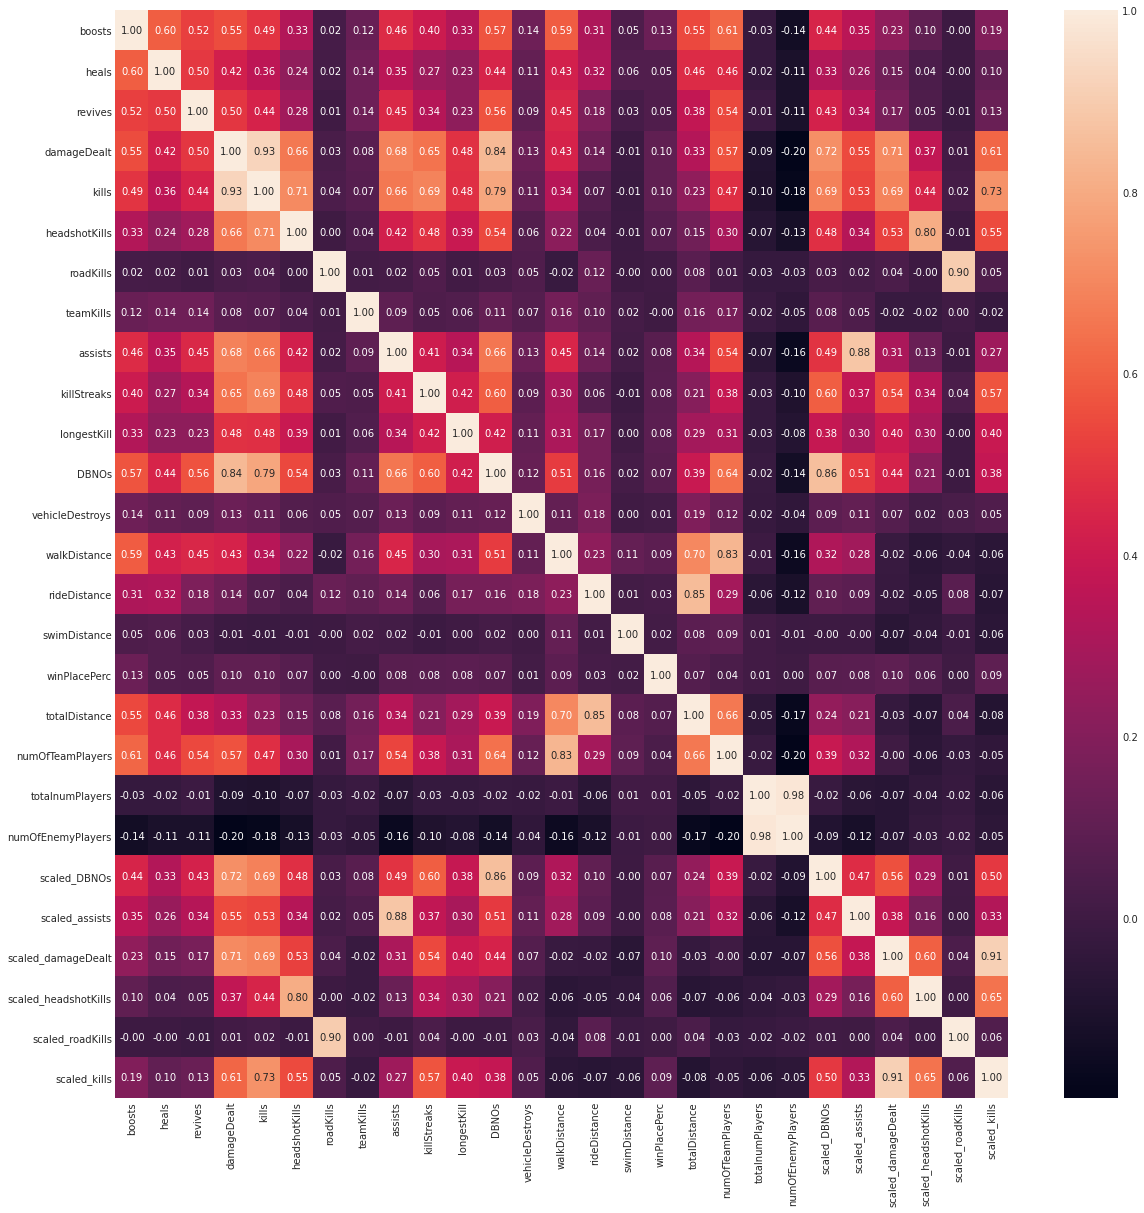

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(
    data=groups_df[groups_df["winGrade"] == "B"].corr(),
    annot=True,
    fmt=".2f"
)

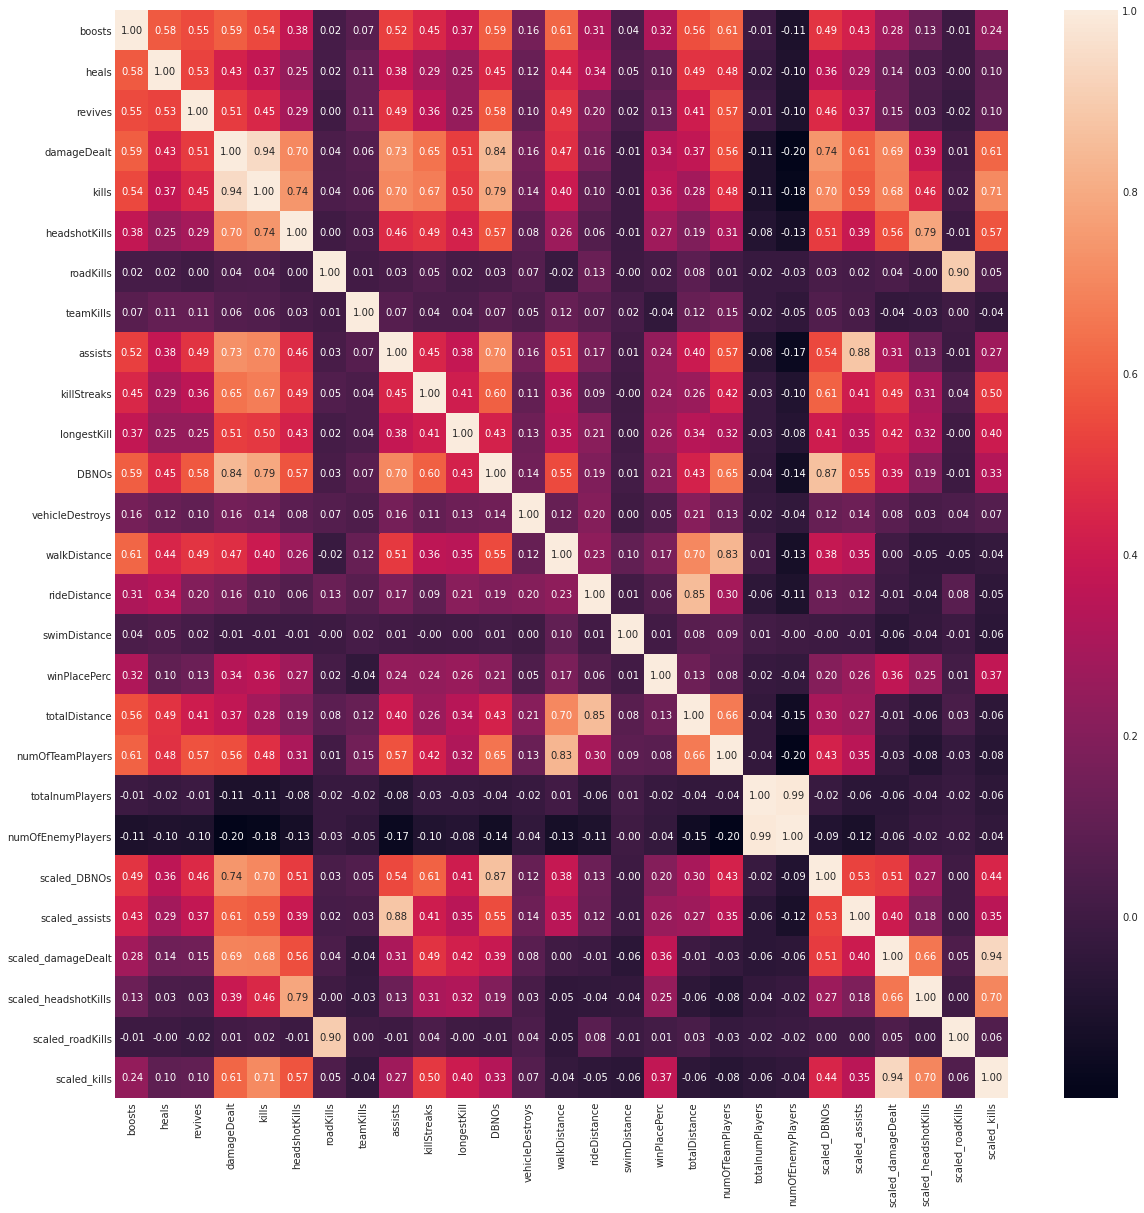

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(
    data=groups_df[groups_df["winPlacePerc"] >= 0.80].corr(),
    annot=True,
    fmt=".2f"
)

In [ ]:
#for col in groups_df.select_dtypes(include=np.number).columns:
    plt.figure(figsize=(20, 15))
    sns.scatterplot(data=groups_df, x="kills", y=col, hue="winGrade")
    plt.show()


IndentationError: ignored

In [ ]:
for col in groups_df.select_dtypes(include=np.number).columns:
    plt.figure(figsize=(20, 15))
    sns.histplot(data=groups_df, x=col, y="scaled_kills", hue="winGrade")
    plt.show()